In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.axes as ax

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product 
from tqdm import tqdm_notebook

# Forecast quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

import ts_plots

# Loading the data: number of ads watched per hour.

In [2]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


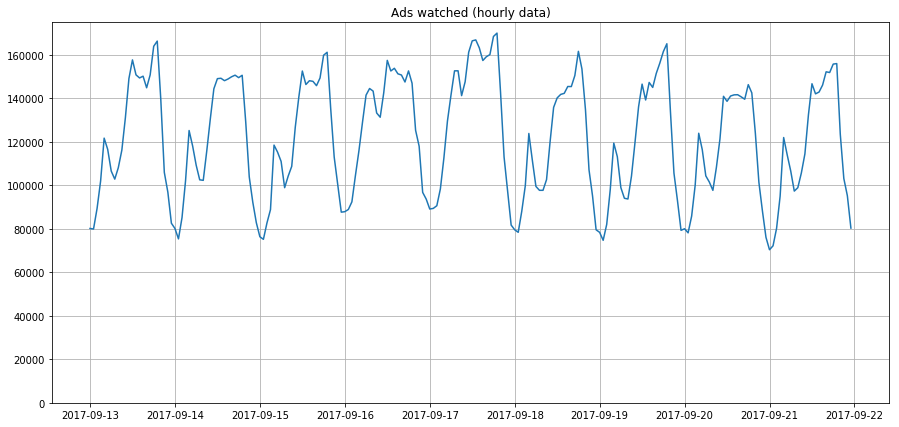

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.ylim(ymin=0)
plt.show()

In [4]:
print(ads.shape)

(216, 1)


# Stationarity

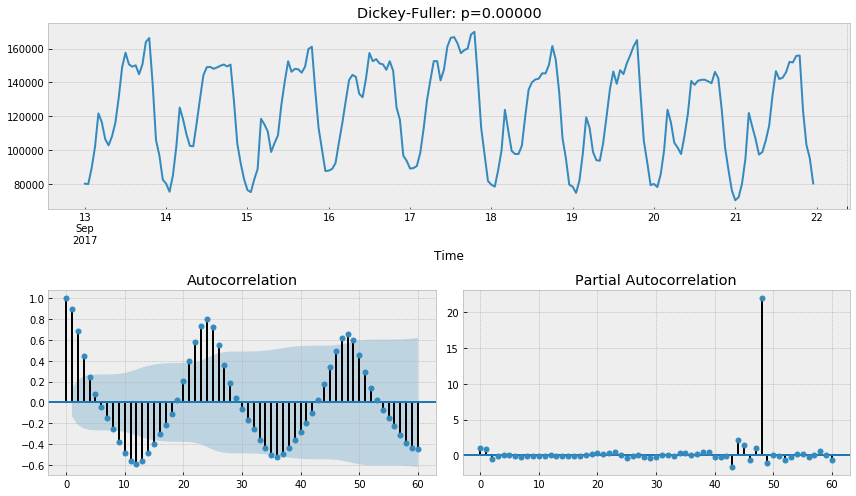

In [5]:
ts_plots.tsplot(ads.Ads, lags=60)

Seasonality difference:

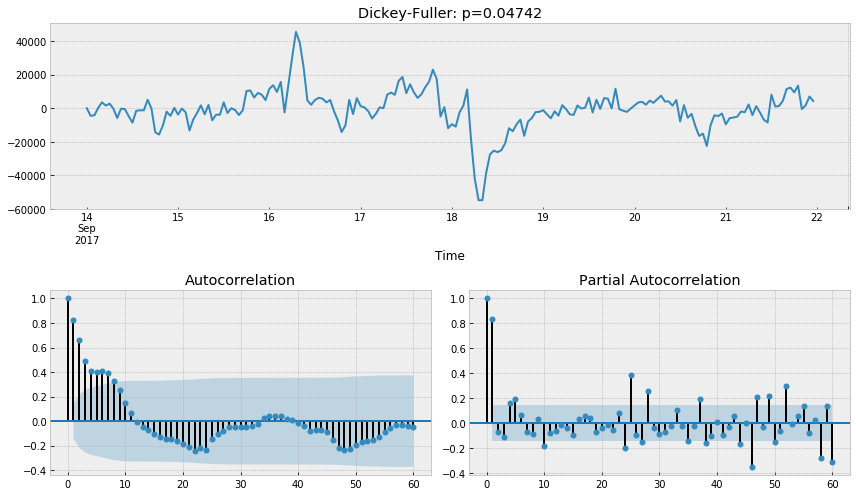

In [6]:
ads_diff = ads.Ads - ads.Ads.shift(24)
ts_plots.tsplot(ads_diff[24:], lags=60)

Take first differences

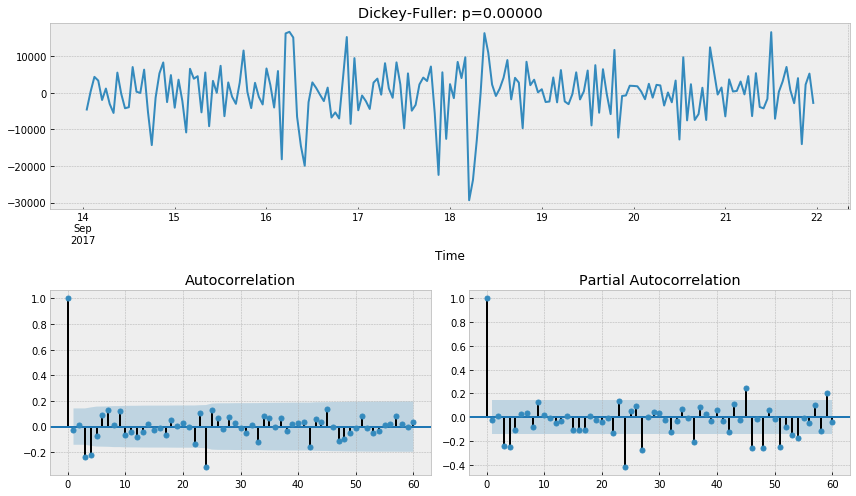

In [7]:
ads_diff = ads_diff - ads_diff.shift(1)
ts_plots.tsplot(ads_diff[24+1:], lags=60)

# Simple linear regression forecast

In [8]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [9]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [10]:
data.head(10)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-13 00:00:00,80115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 01:00:00,79885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 02:00:00,89325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 03:00:00,101930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 04:00:00,121630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 05:00:00,116475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 06:00:00,106495,80115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 07:00:00,102795,79885.0,80115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-13 08:00:00,108055,89325.0,79885.0,80115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [12]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

In [13]:
X.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0,80115.0
2017-09-14 01:00:00,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0,79885.0
2017-09-14 02:00:00,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0,89325.0
2017-09-14 03:00:00,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0,101930.0
2017-09-14 04:00:00,96780.0,105895.0,139520.0,166235.0,163840.0,150690.0,144780.0,150100.0,149295.0,150715.0,157590.0,149020.0,131030.0,116125.0,108055.0,102795.0,106495.0,116475.0,121630.0


In [14]:
X_train, X_test, y_train, y_test = ts_plots.timeseries_train_test_split(X, y, test_size=0.3)

In [15]:
#data.index = data.index.to_datetime()
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1

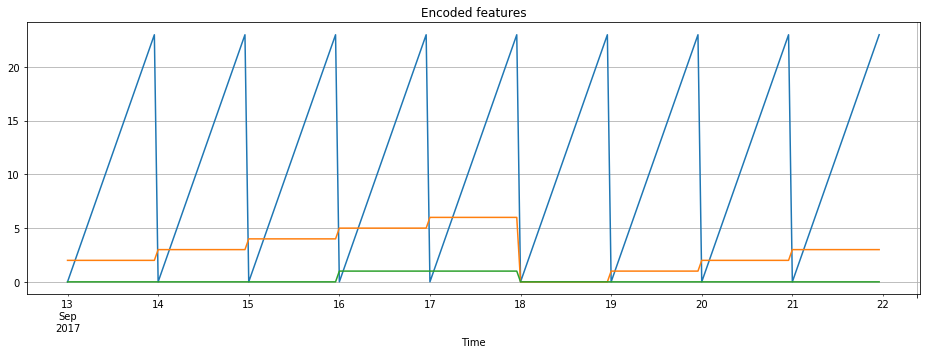

In [16]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = ts_plots.timeseries_train_test_split(X, y, test_size=0.3)

X_d = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_d, columns=X.columns)
X_scaled.index = X.index

X_train_scaled_d = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data=X_train_scaled_d, columns=X_train.columns)
X_train_scaled.index = X_train.index

X_test_scaled_d = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(data=X_test_scaled_d, columns=X_test.columns)
X_test_scaled.index = X_test.index

In [18]:
X_train_scaled.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,1.469567,0.981692,0.757220,0.936341,0.896765,0.933582,1.163991,0.844205,0.178631,-0.382765,...,-0.735281,-0.355589,-0.153402,-0.879017,-1.330165,-1.650954,-1.611938,-1.602148,-0.156017,-0.747087
2017-09-14 01:00:00,1.555736,1.455032,0.970120,0.745222,0.925600,0.882715,0.916794,1.155410,0.839240,0.170396,...,-0.872694,-0.727478,-0.346755,-0.139877,-0.859389,-1.301252,-1.620389,-1.456202,-0.156017,-0.747087
2017-09-14 02:00:00,0.594570,1.541242,1.443830,0.957536,0.735039,0.911552,0.865736,0.905756,1.153939,0.838048,...,-0.677344,-0.865352,-0.721082,-0.333292,-0.123627,-0.834303,-1.273554,-1.310255,-0.156017,-0.747087
2017-09-14 03:00:00,-0.615207,0.579623,1.530107,1.429944,0.946733,0.720980,0.894681,0.854191,0.901482,1.156101,...,-0.377635,-0.669347,-0.859860,-0.707739,-0.316158,-0.104521,-0.810434,-1.164308,-0.156017,-0.747087
2017-09-14 04:00:00,-0.943151,-0.630725,0.567736,1.515983,1.417761,0.932687,0.703395,0.883423,0.849339,0.900953,...,0.175917,-0.368631,-0.662570,-0.846562,-0.688894,-0.295487,-0.086636,-1.018361,-0.156017,-0.747087


R squared:   0.92


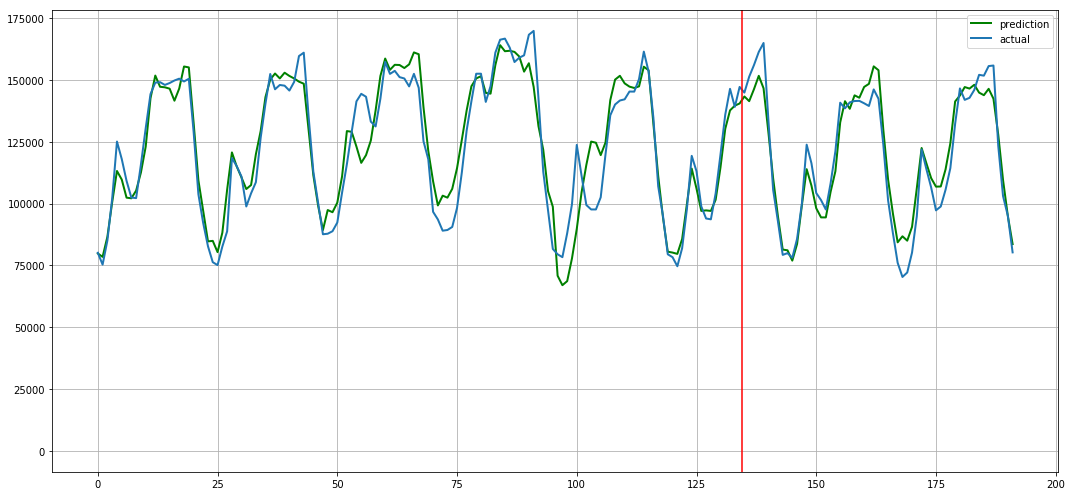

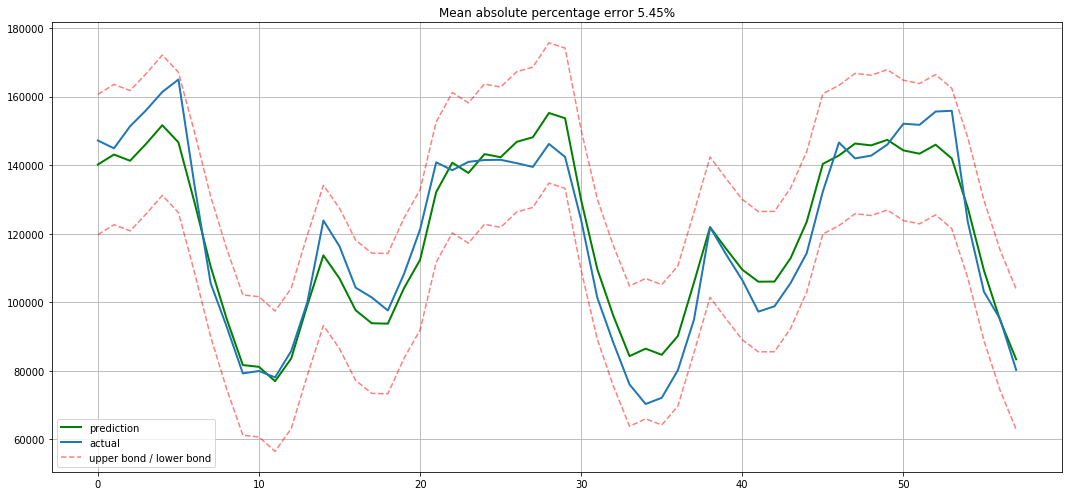

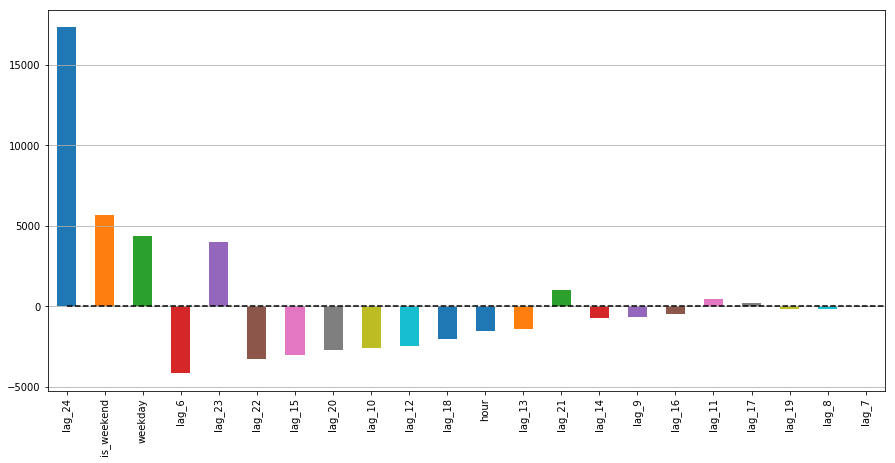

In [19]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
f_test = lr.predict(X_test_scaled)

plt.figure(figsize=(15, 7))
plt.plot(lr.predict(X_scaled), "g", label="prediction", linewidth=2.0)
plt.plot(y.values, label="actual", linewidth=2.0)
plt.plot(0)
plt.axvline(x=(1-0.3) * y.values.size, color="r")
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

ts_plots.plotModelResults(lr, X_train_scaled, X_test_scaled, y_train, y_test, plot_intervals=True, mean_error=True)
ts_plots.plotCoefficients(lr, X_train_scaled)

SS_tot = ((y_test.values - y_test.values.mean()) **2).sum()
SS_res = ((f_test - y_test.values) **2).sum()
print("R squared:   {0:.2f}".format(1 - (SS_res / SS_tot)))

# Regularization and feature selection

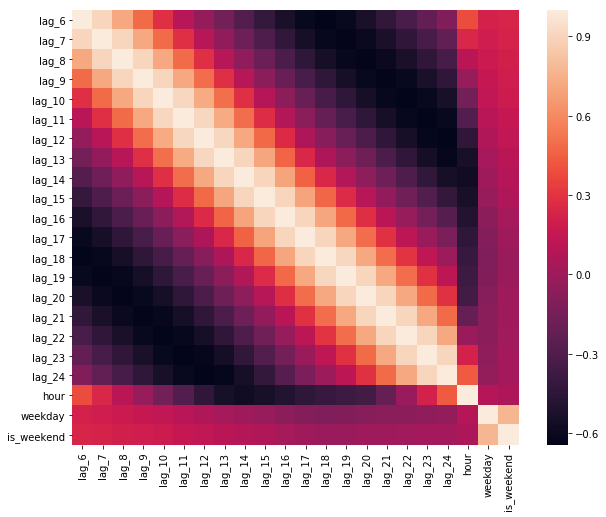

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

In [21]:
from sklearn.linear_model import LassoCV, RidgeCV, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

R squared:   0.92


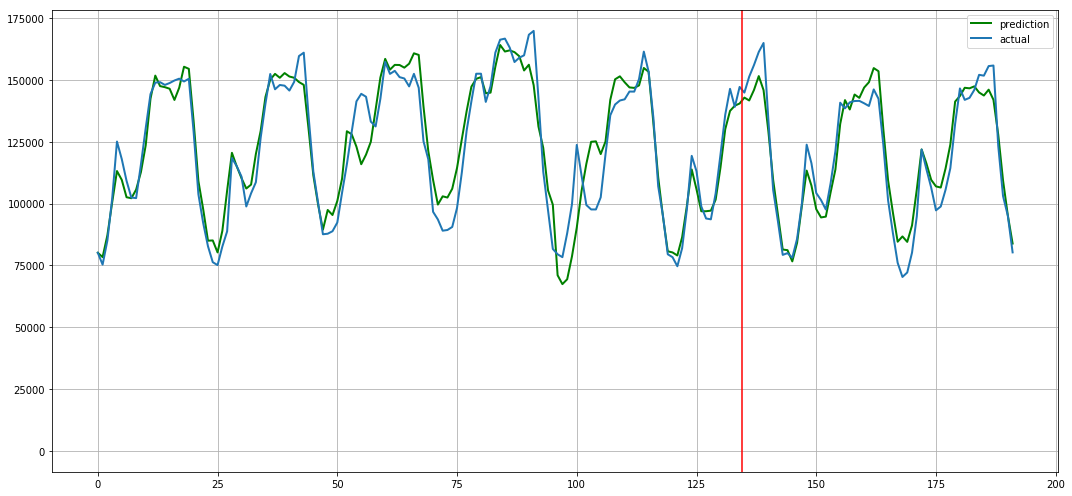

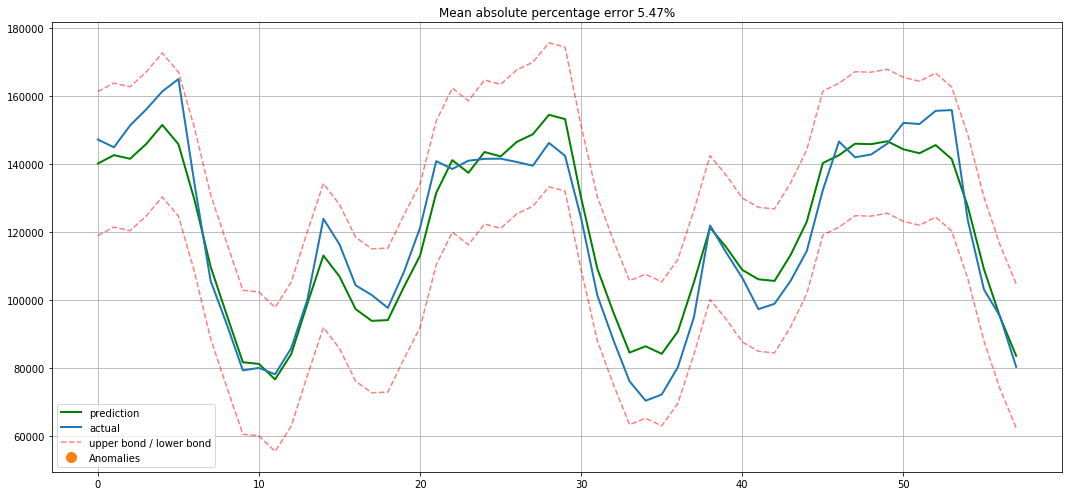

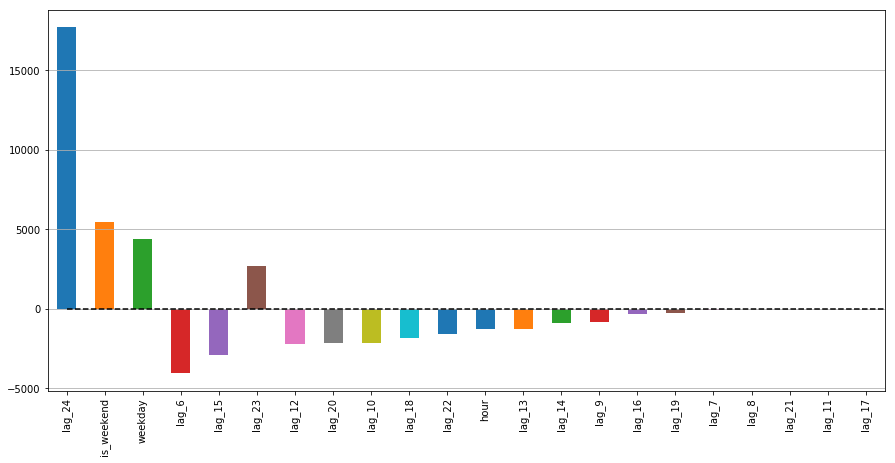

In [22]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)
f_test = lasso.predict(X_test_scaled)

plt.figure(figsize=(15, 7))
plt.plot(lasso.predict(X_scaled), "g", label="prediction", linewidth=2.0)
plt.plot(y.values, label="actual", linewidth=2.0)
plt.plot(0)
plt.axvline(x=(1-0.3) * y.values.size, color="r")
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

ts_plots.plotModelResults(lasso, X_train_scaled, X_test_scaled, y_train, y_test,
                 plot_intervals=True, plot_anomalies=True, mean_error=True)
ts_plots.plotCoefficients(lasso, X_train_scaled)

SS_tot = ((y_test.values - y_test.values.mean()) **2).sum()
SS_res = ((f_test - y_test.values) **2).sum()
print("R squared:   {0:.2f}".format(1 - (SS_res / SS_tot)))

# XGBRegressor

R squared:   0.96


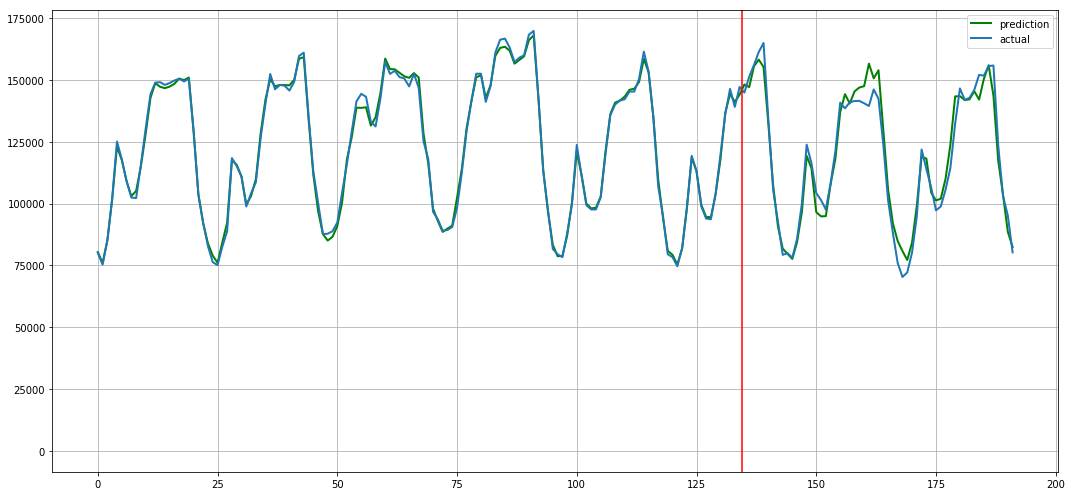

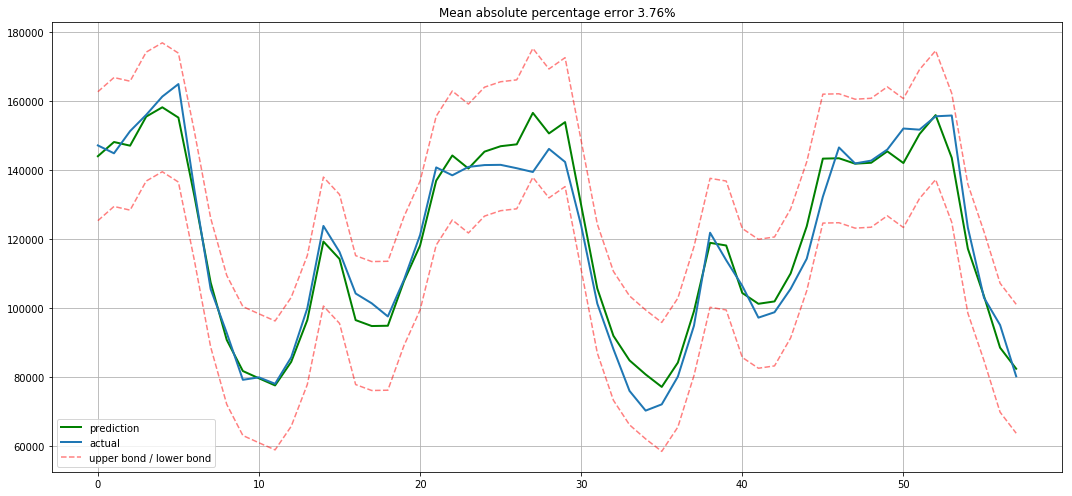

In [23]:
from xgboost import XGBRegressor 

xgb = XGBRegressor(max_depth=3, n_estimators=100)
xgb.fit(X_train, y_train)
f_test = xgb.predict(X_test)

plt.figure(figsize=(15, 7))
plt.plot(xgb.predict(X), "g", label="prediction", linewidth=2.0)
plt.plot(y.values, label="actual", linewidth=2.0)
plt.plot(0)
plt.axvline(x=(1-0.3) * y.values.size, color="r")
plt.legend(loc="best")
plt.tight_layout()
plt.grid(True);

ts_plots.plotModelResults(xgb, X_train, X_test, y_train, y_test, plot_intervals=True, mean_error=True)

SS_tot = ((y_test.values - y_test.values.mean()) **2).sum()
SS_res = ((f_test - y_test.values) **2).sum()
print("R squared:   {0:.2f}".format(1 - (SS_res / SS_tot)))